# Training the model

In [1]:
# importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [2]:
# parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 25

In [3]:
# image and masks path
train_image_dir = 'dataset/unet/train/images'
train_mask_dir = 'dataset/unet/train/masks'
val_image_dir = 'dataset/unet/valid/images'
val_mask_dir = 'dataset/unet/valid/masks'
test_image_dir = 'dataset/unet/test/images'
test_mask_dir = 'dataset/unet/test/masks'

In [4]:
# data augmentation configuration
train_image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_mask_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_image_datagen = ImageDataGenerator(rescale=1./255)
val_mask_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# generators
train_image_generator = train_image_datagen.flow_from_directory(
    train_image_dir,
    classes=[''],
    class_mode=None,  # classes nh h dataset ma, only 1 class
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True)

train_mask_generator = train_mask_datagen.flow_from_directory(
    train_mask_dir,
    classes=[''],
    class_mode=None,  # classes nh h dataset ma, only 1 class
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True)

val_image_generator = val_image_datagen.flow_from_directory(
    val_image_dir,
    classes=[''],
    class_mode=None,  # classes nh h dataset ma, only 1 class
    color_mode='rgb',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True)

val_mask_generator = val_mask_datagen.flow_from_directory(
    val_mask_dir,
    classes=[''],
    class_mode=None,  # classes nh h dataset ma, only 1 class
    color_mode='grayscale',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True)

Found 140 images belonging to 1 classes.
Found 140 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


In [6]:
def combined_generator(image_generator, mask_generator):
    while True:
        x_batch = image_generator.__next__()
        y_batch = mask_generator.__next__()
        yield x_batch, y_batch

In [7]:
# combine generators
train_gen = combined_generator(train_image_generator, train_mask_generator)
val_gen = combined_generator(val_image_generator, val_mask_generator)

In [8]:
# test the generator
x, y = next(train_gen)
print("Image batch shape:", x.shape)
print("Mask batch shape:", y.shape)

Image batch shape: (8, 256, 256, 3)
Mask batch shape: (8, 256, 256, 1)


In [9]:
# define U-Net model
def unet_model():
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Contraction path
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [10]:
# create model
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1])])

In [12]:
# define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('models/best_model.keras', verbose=1, save_best_only=True)
]

In [13]:
# calculate steps per epoch based on generator length
train_steps = len(train_image_generator)
val_steps = len(val_image_generator)

In [23]:
# train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/25

Epoch 1: val_loss did not improve from 0.40645
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 678ms/step - accuracy: 0.8118 - io_u: 0.0000e+00 - loss: 0.4109 - val_accuracy: 0.8447 - val_io_u: 0.0000e+00 - val_loss: 0.4127
Epoch 2/25

Epoch 2: val_loss improved from 0.40645 to 0.38980, saving model to models/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 699ms/step - accuracy: 0.7932 - io_u: 0.0000e+00 - loss: 0.4471 - val_accuracy: 0.8491 - val_io_u: 0.0000e+00 - val_loss: 0.3898
Epoch 3/25

Epoch 3: val_loss did not improve from 0.38980
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 737ms/step - accuracy: 0.7985 - io_u: 0.0000e+00 - loss: 0.4337 - val_accuracy: 0.8432 - val_io_u: 0.0000e+00 - val_loss: 0.4190
Epoch 4/25

Epoch 4: val_loss improved from 0.38980 to 0.33947, saving model to models/best_model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 730ms/step - accuracy: 0.7861 - io_u: 0.0000e+00 - loss: 0.4582 - val_accuracy: 0.8595 - val_io_u: 0.0000e+00 - val_loss: 0.3395
Epoch 5/25

Epoch 5: val_loss did 

# Testing the model

In [24]:
test_images = []
test_masks = []

In [25]:
for img_name in os.listdir(test_image_dir):
    img = cv2.imread(os.path.join(test_image_dir, img_name))
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img / 255.0
    test_images.append(img)

for mask_name in os.listdir(test_mask_dir):
    mask = cv2.imread(os.path.join(test_mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask / 255.0
    test_masks.append(mask)

In [26]:
test_images = np.array(test_images)
test_masks = np.array(test_masks)
test_masks = np.expand_dims(test_masks, axis=-1)

In [27]:
# load best model
model = tf.keras.models.load_model('models/best_model.keras')

In [28]:
# evaluate
results = model.evaluate(test_images, test_masks, batch_size=BATCH_SIZE)
print(f'Test Loss: {results[0]}, Test Accuracy: {results[1]}, Test IoU: {results[2]}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.8475 - io_u: 0.0000e+00 - loss: 0.3772
Test Loss: 0.3836769461631775, Test Accuracy: 0.8451004028320312, Test IoU: 0.0


In [29]:
# make predictions
predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


In [30]:
# visualization function
def plot_sample(index):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(test_images[index])
    plt.title('Input Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[index].squeeze(), cmap='gray')
    plt.title('Actual Mask')
    
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[index].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()

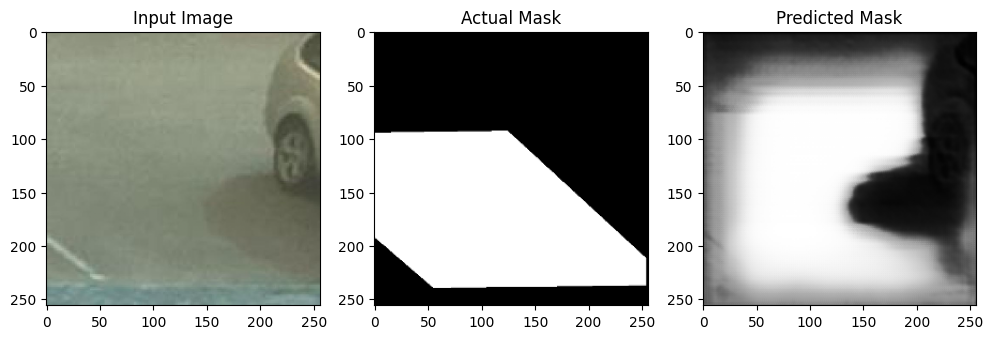

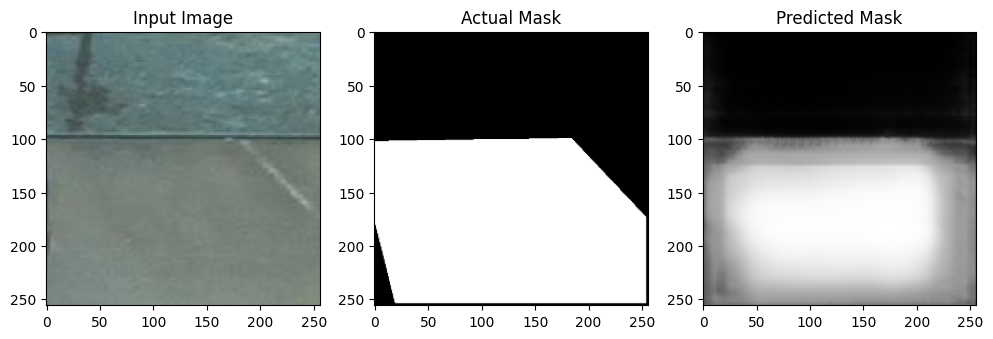

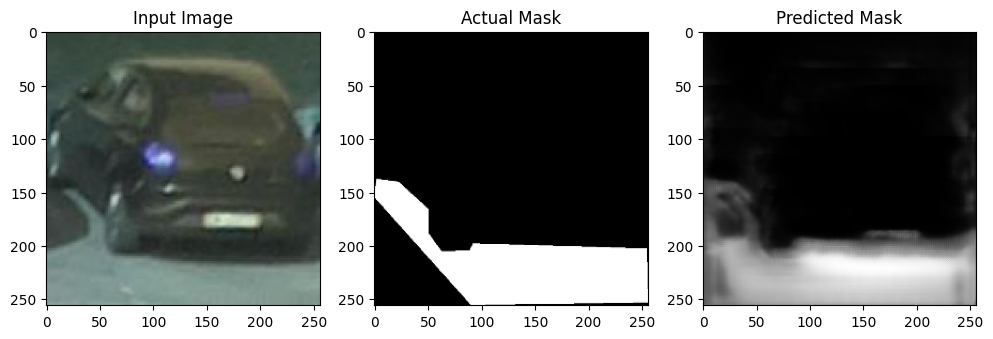

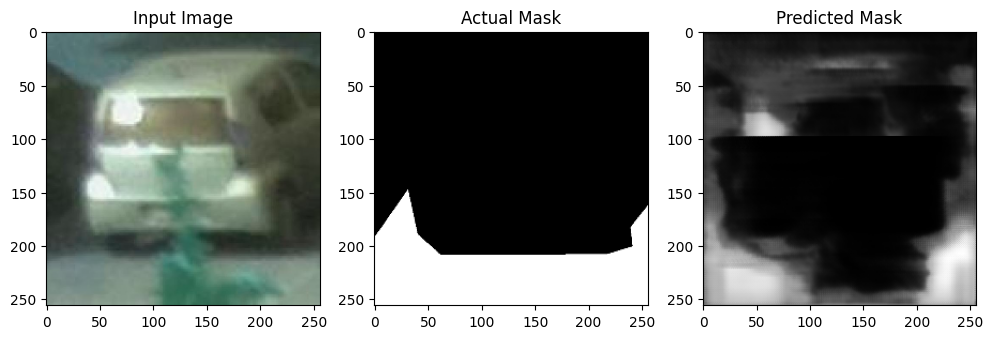

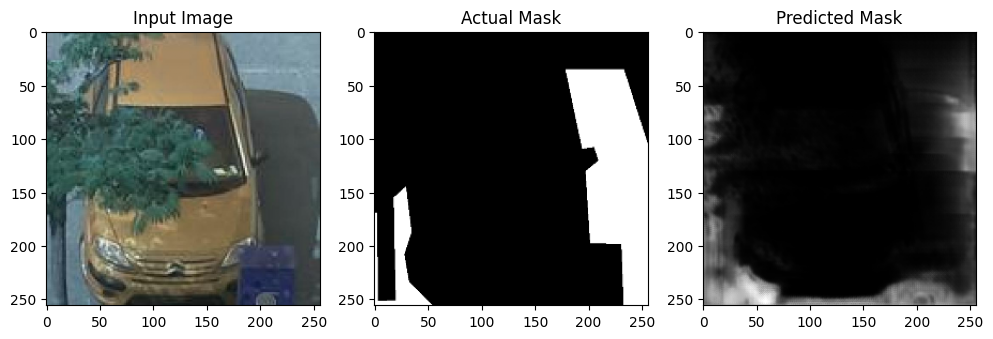

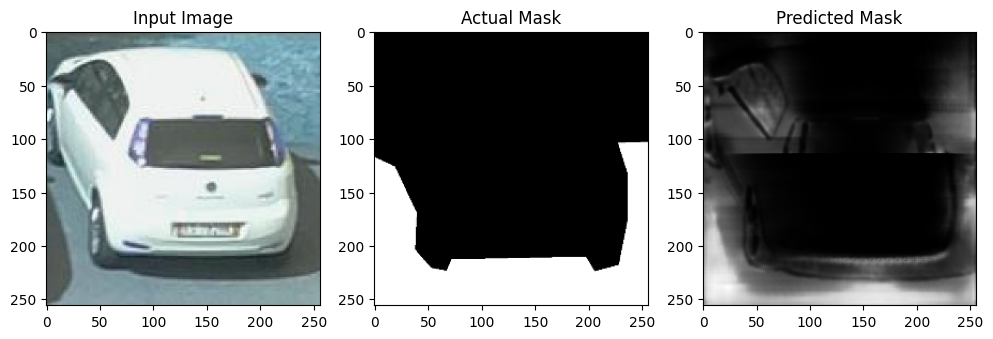

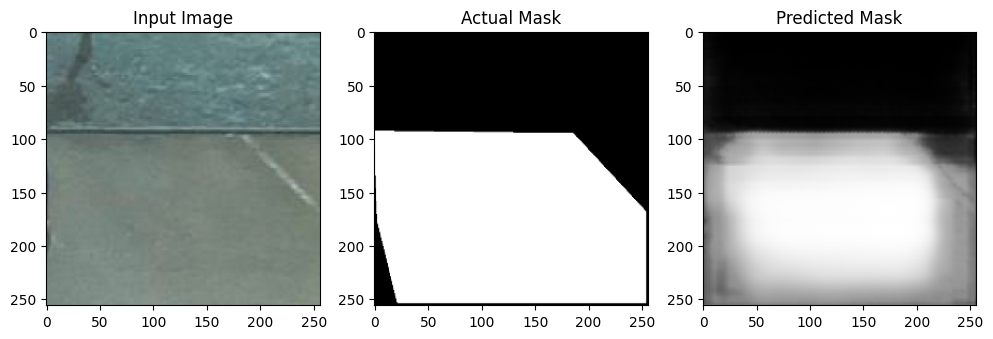

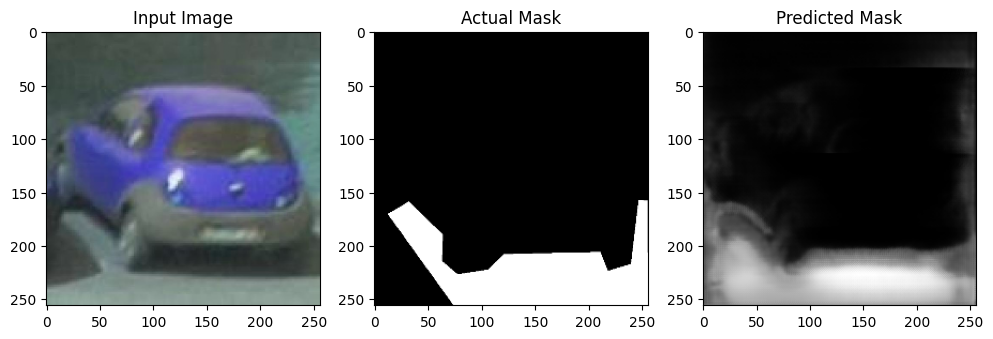

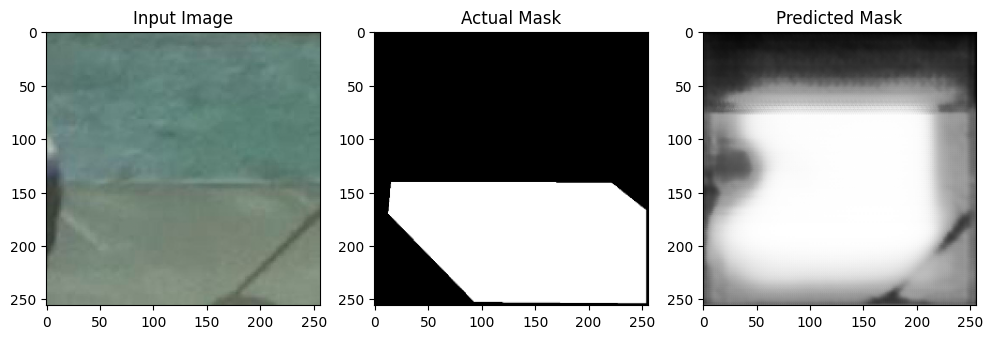

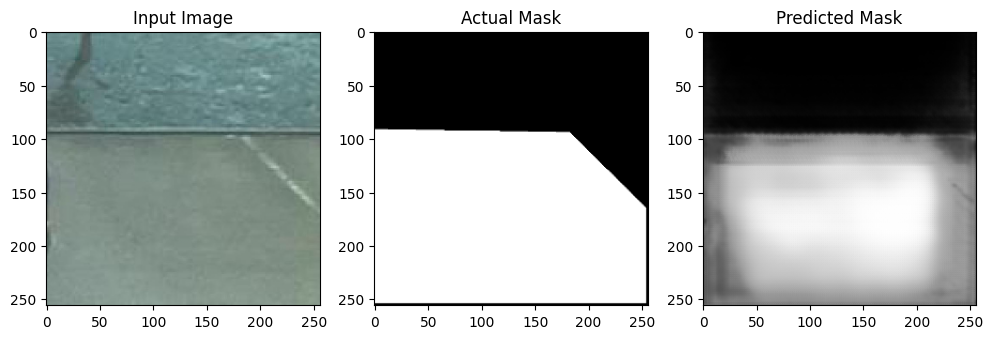

In [31]:
# visualize some predictions
for i in range(10):
    plot_sample(i)